In [1]:
import os
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing

image_size_full = 256 #256 full in 768

In [2]:
import os
import torch
import numpy as np
import cv2  # OpenCV for image processing
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, images_path, masks_path, patch_size=256, augment=True):
        self.images_path = images_path
        self.masks_path = masks_path

        valid_image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')
        self.image_files = sorted([f for f in os.listdir(images_path) if not f.startswith('.') and f.lower().endswith(valid_image_extensions)])
        self.mask_files = sorted([f for f in os.listdir(masks_path) if not f.startswith('.') and f.lower().endswith(valid_image_extensions)])

        self.patch_size = patch_size
        self.augment = augment

        # Augmentazioni
        self.augmentations = A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=15, p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.GaussianBlur(blur_limit=3, p=0.2),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
                A.CLAHE(clip_limit=2, p=0.3),
            ],
            additional_targets={"mask": "image"},
        )

    def __len__(self):
        # Numero totale di patch = numero di immagini * (num_patch_row * num_patch_col)
        num_patches_per_image = (2048 // self.patch_size) ** 2
        return len(self.image_files) * num_patches_per_image

    def __getitem__(self, idx):
        # Determina l'immagine e la patch corrispondente
        image_idx = idx // ((2048 // self.patch_size) ** 2)  # Indice dell'immagine
        patch_idx = idx % ((2048 // self.patch_size) ** 2)  # Indice della patch nella griglia

        # Carica immagine e maschera
        image_path = os.path.join(self.images_path, self.image_files[image_idx])
        
        mask_path = os.path.join(self.masks_path, self.mask_files[image_idx])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8) / 255

        # Trasforma la maschera in valori binari (0 e 1)
        # mask = (mask > 127).astype(np.uint8)

        # Calcola la posizione della patch
        row = patch_idx // (2048 // self.patch_size)
        col = patch_idx % (2048 // self.patch_size)
        y_start = row * self.patch_size
        x_start = col * self.patch_size
        y_end = y_start + self.patch_size
        x_end = x_start + self.patch_size

        # Estrai la patch
        image_patch = image[y_start:y_end, x_start:x_end]
        mask_patch = mask[y_start:y_end, x_start:x_end]

        # Applica augmentazioni, se richiesto
        if self.augment:
            augmented = self.augmentations(image=image_patch, mask=mask_patch)
            image_patch, mask_patch = augmented["image"], augmented["mask"]

        # Estrai le coordinate e le intensità per la patch
        coords_intensities = self.generate_coords_intensities(image_patch)

        return coords_intensities, torch.tensor(mask_patch.flatten(), dtype=torch.long)

    def generate_coords_intensities(self, image_patch, device='mps'):
        """
        Genera coordinate normalizzate e intensità per una patch.
        Args:
            image_patch (numpy.ndarray o torch.Tensor): Patch di immagine (H, W) o (C, H, W).
            device (torch.device, opzionale): Dispositivo su cui spostare i tensori.
        Returns:
            torch.Tensor: Tensore contenente coordinate e intensità (H*W, 3).
        """
        # Se image_patch è un tensore Torch, spostalo sulla CPU per numpy
        if isinstance(image_patch, torch.Tensor):
            image_patch = image_patch.cpu().numpy()

        # Controlla il formato di input e riduci a (H, W) se necessario
        if len(image_patch.shape) == 3:  # (C, H, W)
            if image_patch.shape[0] == 1:  # Caso di un canale (1, H, W)
                image_patch = image_patch.squeeze(0)  # Rimuovi il canale
            elif image_patch.shape[0] == 3:  # Caso RGB (3, H, W)
                image_patch = np.mean(image_patch, axis=0)  # Converti in scala di grigi

        if len(image_patch.shape) != 2:
            raise ValueError(f"Expected image_patch to have 2 dimensions (H, W), but got {image_patch.shape}")

        # Estrai H e W
        H, W = image_patch.shape

        # Crea le coordinate normalizzate
        y_coords, x_coords = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
        coords = np.stack((x_coords, y_coords), axis=-1).reshape(-1, 2).astype(np.float32)
        coords /= np.array([W - 1, H - 1], dtype=np.float32)

        # Estrai le intensità
        intensities = image_patch.flatten().reshape(-1, 1)
        coords_intensities = np.concatenate([coords, intensities], axis=-1)

        # Converti in tensore Torch
        tensor = torch.tensor(coords_intensities, dtype=torch.float32)

        # Sposta il tensore sul dispositivo specificato, se fornito
        if device is not None:
            tensor = tensor.to(device)

        return tensor



/opt/anaconda3/envs/retina/lib/python3.10/site-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [Errno 61] Connection refused>
  data = fetch_version_info()


In [3]:
from torch.utils.data import DataLoader

# Define paths to your image and mask directories
# images_path = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_images' #'path/to/images'
# masks_path = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_masks' #'path/to/masks'

images_path = '/Users/Q540900/Desktop/retina_segmentation_with_Implicit_Neural_Representation/new_dataset/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original' #'path/to/images'
masks_path = '/Users/Q540900/Desktop/retina_segmentation_with_Implicit_Neural_Representation/new_dataset/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Ground truth' #'path/to/masks'
# Create dataset and dataloader
batch_size = 128    # Adjust based on your GPU memory

dataset = SegmentationDataset(images_path, masks_path, patch_size=image_size_full, augment=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

coords_intensities, sampled_labels = next(iter(dataloader))
print(coords_intensities.shape, sampled_labels.shape)

/opt/anaconda3/envs/retina/lib/python3.10/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


torch.Size([128, 65536, 3]) torch.Size([128, 65536])


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, num_freqs):
        super(PositionalEncoding, self).__init__()
        self.num_freqs = num_freqs

    def forward(self, x):
        frequencies = torch.linspace(0, self.num_freqs - 1, self.num_freqs, device=x.device)
        frequencies = 2.0 ** frequencies  # Forma: (num_freqs,)
        frequencies = frequencies.view(1, 1, -1)  # Forma: (1, 1, num_freqs)

        x = x.unsqueeze(-1)  # Forma: (N, num_coords, 1)
        x = x * frequencies  # Broadcasting, forma: (N, num_coords, num_freqs)
        x = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)  # (N, num_coords, num_freqs * 2)
        x = x.view(x.shape[0], -1)  # Appiattisce in (N, num_coords * num_freqs * 2)
        return x


class AdaptiveDropout(nn.Module):
    def __init__(self, initial_p=0.5, decay_factor=0.95):
        super(AdaptiveDropout, self).__init__()
        self.p = initial_p
        self.decay_factor = decay_factor

    def forward(self, x):
        if self.training:
            return F.dropout(x, p=self.p, training=True)
        else:
            return x

    def step(self):
        self.p *= self.decay_factor  # Decresce la probabilità di dropout


import torch.nn.functional as F

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=1.0):
        super(SineLayer, self).__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features

        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                self.linear.weight.uniform_(
                    -np.sqrt(6 / self.in_features) / self.omega_0,
                    np.sqrt(6 / self.in_features) / self.omega_0,
                )

    def forward(self, x):
        x = self.linear(x)
        x = torch.sin(self.omega_0 * x)
        return x


import torch
import torch.nn as nn
import torch.nn.functional as F

class INRSegmentationModel(nn.Module):
    def __init__(self, num_classes=2, hidden_dim=256, num_layers=5, num_freqs=10, initial_dropout_p=0.5, outermost_linear=False, linear_network=False):
        super(INRSegmentationModel, self).__init__()
        self.num_classes = num_classes
        self.pos_enc = PositionalEncoding(num_freqs)

        # Calcola input_dim in base alla dimensione della codifica posizionale
        num_coords = 2  # Supponendo (x, y)
        input_dim = num_coords * num_freqs * 2 + 1  # +1 per l'intensità

        self.linear_network = linear_network
        self.outermost_linear = outermost_linear

        # Riduzione dimensionale iniziale
        self.reduction_layer = nn.Linear(input_dim, hidden_dim)

        # Dropout adattivo per evitare overfitting
        self.dropouts = nn.ModuleList([AdaptiveDropout(initial_dropout_p) for _ in range(num_layers - 1)])

        # Multi-Layer Perceptron (MLP)
        self.mlp = nn.ModuleList()

        # Primo strato
        self.mlp.append(
            nn.Sequential(
                SineLayer(in_features=hidden_dim, out_features=hidden_dim, is_first=True),
                nn.BatchNorm1d(hidden_dim),  # Stabilizza il training
            )
        )

        # Strati intermedi
        for _ in range(1, num_layers - 2):
            if linear_network:
                self.mlp.append(
                    nn.Sequential(
                        nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
                        nn.ReLU(),
                        nn.BatchNorm1d(hidden_dim),
                    )
                )
            else:
                self.mlp.append(
                    nn.Sequential(
                        SineLayer(in_features=hidden_dim, out_features=hidden_dim),
                        nn.BatchNorm1d(hidden_dim),
                    )
                )

        # Strato finale senza attivazione
        if outermost_linear:
            # self.mlp.append(nn.Linear(hidden_dim, num_classes))  # Uscita lineare per più classi
            self.mlp.append(nn.Linear(hidden_dim, 1))
        else:
            self.mlp.append(nn.Linear(hidden_dim, 1))  # Uscita lineare per classificazione binaria


    def forward(self, coords_intensities):
        # Estrai coordinate e intensità
        coords = coords_intensities[:, :-1]  # Shape: (N, num_coords)
        intensities = coords_intensities[:, -1].unsqueeze(-1)  # Shape: (N, 1)

        # print(f"Coords Shape: {coords.shape}")
        # print(f"Intensities Shape: {intensities.shape}")

        # Codifica posizionale
        x = self.pos_enc(coords)  # Shape: (N, encoded_features)
        # print(f"After Positional Encoding Shape: {x.shape}")

        x = torch.cat([x, intensities], dim=-1)  # Concatenazione con intensità
        # print(f"After Concatenation Shape: {x.shape}")

        # Riduzione dimensionale iniziale
        x = self.reduction_layer(x)  # Shape: (N, hidden_dim)
        # print(f"After Reduction Layer Shape: {x.shape}")

        # Passa attraverso gli strati MLP
        for i, layer in enumerate(self.mlp[:-1]):
            x = layer(x)
            if x is None:
                raise ValueError(f"Layer {i} returned None")
            x = self.dropouts[i](x)

        # Strato finale senza attivazione
        x = self.mlp[-1](x)

        # Applicazione dell'attivazione finale
        if self.outermost_linear:
            x = F.softmax(x, dim=-1)
        else:
            x = torch.sigmoid(x)

        return x


# Configurazione del dispositivo
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")


Using device: mps


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2, smooth=1):
        super(FocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        """
        Inputs: probabilità predette dal modello (output di Sigmoid)
        Targets: maschere binarie (valori 0 o 1)
        """
        # Sigmoid è già applicato nel modello, quindi inputs sono probabilità
        inputs = torch.clamp(inputs, 1e-7, 1 - 1e-7)  # Stabilizza log per evitare NaN

        # Calcolo della Focal Loss
        focal_loss = -self.alpha * (1 - inputs) ** self.gamma * targets * torch.log(inputs) - \
                     (1 - self.alpha) * inputs ** self.gamma * (1 - targets) * torch.log(1 - inputs)
        focal_loss = focal_loss.mean()

        # Calcolo della Dice Loss
        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (union + self.smooth)

        # Combina le perdite
        total_loss = focal_loss + dice_loss

        return total_loss

In [6]:
# Configurazione dei parametri
num_classes = 2  # Segmentazione binaria
num_layers = 6
hidden_dim = image_size_full  # Usa la dimensione dell'immagine
outer_layer_linear = False
num_freq = 5
linear_network = False
alpha = 0.75
gamma = 2
smooth = 1e-5

In [ ]:
# Import delle librerie necessarie
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
import torch.optim as optim
import torch
import torch.nn as nn

# Inizializzazione del modello
model = INRSegmentationModel(
    num_classes=num_classes,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    outermost_linear=outer_layer_linear,
    num_freqs=num_freq,
    linear_network=linear_network,
).to(device)

# model.load_state_dict(torch.load('retina_segmentation_model_new_dataset_1.pth'))

# Ottimizzatore
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Funzione di perdita
criterion = FocalDiceLoss(alpha=alpha, gamma=gamma, smooth=smooth).to(device)

# Scheduler: puoi scegliere tra ReduceLROnPlateau o CosineAnnealingWarmRestarts
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10, verbose=True)
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2, eta_min=1e-6)

# Parametri di training
num_epochs = 50
losses = []

best_loss = 1.2

# Ciclo di training
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for coords_intensities, labels in dataloader:
        # Sposta i dati sul dispositivo
        coords_intensities, labels = coords_intensities.to(device), labels.to(device)
        # print(f"Coords and Intensities: {coords_intensities}")
        # print(f"Labels: {labels}")
        # Azzeramento dei gradienti
        optimizer.zero_grad()

        coords_intensities = coords_intensities.view(-1, 3)
        labels = labels.view(-1)
        # Forward pass
        outputs = model(coords_intensities)

        # Reshape degli output e dei target
        outputs = outputs.squeeze(-1)  # Per segmentazione binaria
        # labels = labels.view(-1)  # Assicurati che il target abbia la stessa forma

        # Calcolo della perdita
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulo della perdita
        epoch_loss += loss.item()

    # Perdita media per epoca
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)

    # Aggiorna il learning rate con lo scheduler
    scheduler.step(epoch_loss)

    # Salvataggio del modello e stampa del progresso
    if epoch == 0 or (epoch + 1) % 1 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, LR: {current_lr}')
        # torch.save({
        #     'epoch': epoch,
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'loss': epoch_loss,
        # }, f'model_checkpoint_epoch_{epoch + 1}.pth')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'retina_segmentation_model_new_dataset_1.pth')
        print('Model saved!!!!')


/opt/anaconda3/envs/retina/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Loss: 0.9524, LR: 1e-05
Model saved!!!!
Epoch [2/50], Loss: 0.9465, LR: 1e-05
Model saved!!!!
Epoch [3/50], Loss: 0.9411, LR: 1e-05
Model saved!!!!
Epoch [4/50], Loss: 0.9362, LR: 1e-05
Model saved!!!!
Epoch [5/50], Loss: 0.9324, LR: 1e-05
Model saved!!!!
Epoch [6/50], Loss: 0.9291, LR: 1e-05
Model saved!!!!
Epoch [7/50], Loss: 0.9263, LR: 1e-05
Model saved!!!!
Epoch [8/50], Loss: 0.9239, LR: 1e-05
Model saved!!!!


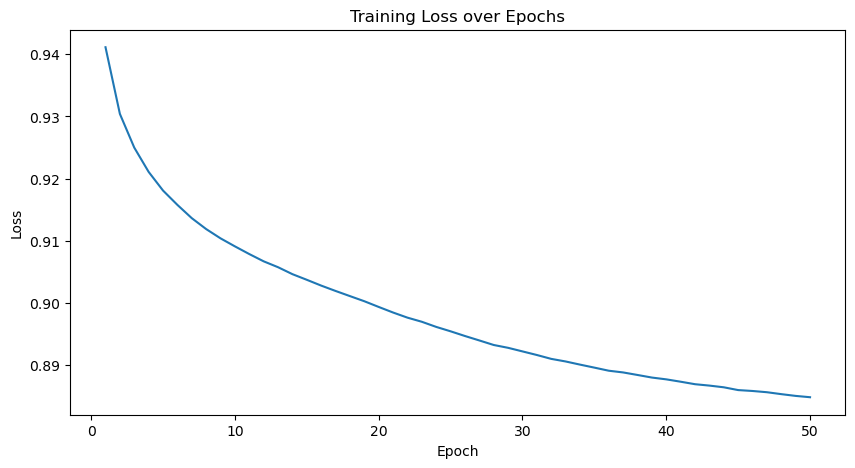

In [15]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [16]:
name_of_model = 'retina_segmentation_model_new_dataset_1.pth'

In [17]:
torch.save(model.state_dict(), name_of_model)

In [18]:
# Esegui la valutazione
test_image_path = "/Users/Q540900/Desktop/retina_segmentation_with_Implicit_Neural_Representation/new_dataset/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Original/1_A.png"
test_mask_path = "/Users/Q540900/Desktop/retina_segmentation_with_Implicit_Neural_Representation/new_dataset/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Ground truth/1_A.png"

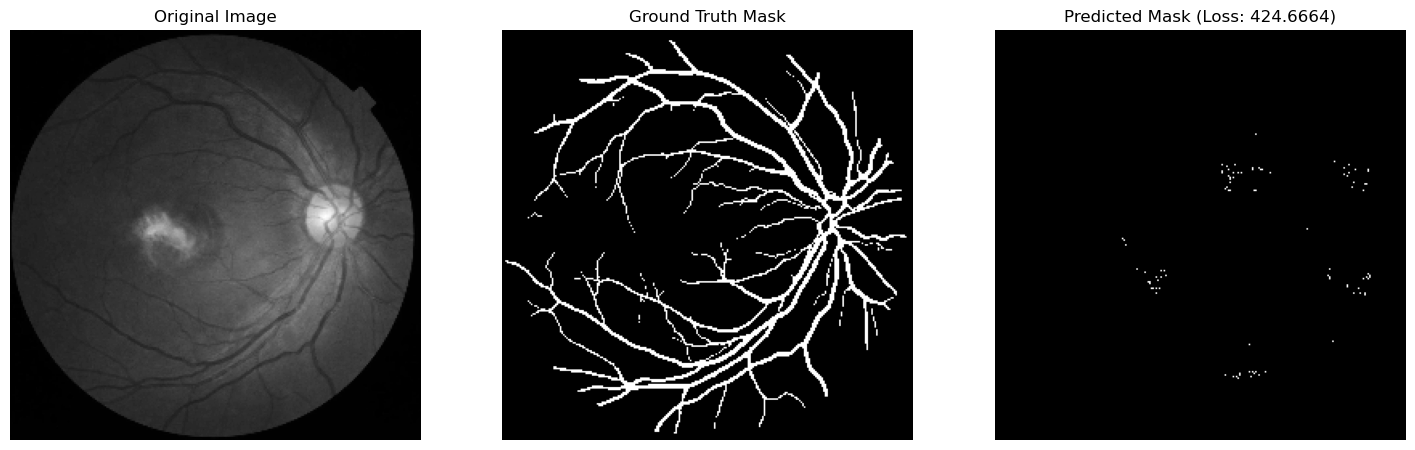

In [19]:
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Funzione per suddividere l'immagine in patch
def split_into_patches(image, patch_size):
    """
    Divide un'immagine in patch di dimensione specificata.
    """
    _, H, W = image.shape  # Ignoriamo il canale
    patches = []
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch = image[:, i:i + patch_size, j:j + patch_size]
            patches.append(patch)
    return patches

# Funzione per ricostruire l'immagine dalle patch
def reconstruct_from_patches(patches, image_shape, patch_size):
    """
    Ricostruisce l'immagine originale dai patch.
    """
    # image_shape dovrebbe essere una tupla (H, W), quindi possiamo usarla direttamente
    H, W = image_shape  # Usa direttamente la forma corretta (altezza, larghezza)
    reconstructed_image = torch.zeros((H, W), device=patches[0].device)  # Assicurati che sia sullo stesso dispositivo
    count_map = torch.zeros((H, W), device=patches[0].device)  # Per calcolare la media nei bordi sovrapposti

    patch_index = 0
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            h_patch, w_patch = patches[patch_index].shape[1:]
            reconstructed_image[i:i + h_patch, j:j + w_patch] += patches[patch_index][0].to(reconstructed_image.device)
            count_map[i:i + h_patch, j:j + w_patch] += 1
            patch_index += 1

    # Evita la divisione per zero
    count_map = torch.clamp(count_map, min=1)
    reconstructed_image /= count_map

    return reconstructed_image


# Funzione aggiornata per valutare il modello
def evaluate_model(model, dataset, image, mask, patch_size, criterion):
    model.eval()

    # Prepara l'immagine per PyTorch
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    mask_tensor = torch.tensor(mask, dtype=torch.long).to(device)

    # Rimuoviamo la dimensione batch prima di dividere in patch
    image_tensor = image_tensor.squeeze(0)

    # Suddividi immagine in patch
    patches_image = split_into_patches(image_tensor, patch_size)

    predicted_patches = []
    losses = []

    for img_patch in patches_image:
        H, W = img_patch.shape[1:]
        coords_intensities = dataset.generate_coords_intensities(img_patch, device=device)

        with torch.no_grad():
            outputs = model(coords_intensities)  # Output per ogni pixel
            outputs = outputs.squeeze(-1).view(H, W)  # Riorganizza come immagine 2D

            # Predizioni binarie
            predicted_labels = (outputs > 0.5).long()
            predicted_patches.append(predicted_labels.unsqueeze(0))

            # Calcola la perdita
            # targets = img_patch.view(-1)
            targets = img_patch.reshape(-1)

            loss = criterion(outputs.view(-1), targets)
            losses.append(loss.item())

    # Ricostruisci l'immagine predetta
    # predicted_mask = reconstruct_from_patches(predicted_patches, image_tensor.shape[2:], patch_size).cpu().numpy()
    # Modifica questa linea
    predicted_mask = reconstruct_from_patches(predicted_patches, image_tensor.shape[1:], patch_size).cpu().numpy()


    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Calcola la perdita totale
    total_loss = sum(losses)

    # Visualizza i risultati
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted Mask (Loss: {total_loss:.4f})")

    plt.show()

# Esegui la valutazione

# Carica immagine e maschera
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (256, 256), interpolation=cv2.INTER_LINEAR)

test_mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.resize(test_mask, (256, 256), interpolation=cv2.INTER_NEAREST)

# Passa il dataset per accedere alla funzione generate_coords_intensities
evaluate_model(model, dataset, test_image, test_mask, patch_size=64, criterion=criterion)


In [20]:
# import os
# import cv2
# import numpy as np

# def extract_patches(image, patch_size=64, stride=64):
#     """
#     Suddivide l'immagine in patch di dimensione patch_size x patch_size,
#     scorrendo con passo 'stride'.
#     """
#     patches = []
#     h, w = image.shape[:2]
    
#     for y in range(0, h - patch_size + 1, stride):
#         for x in range(0, w - patch_size + 1, stride):
#             patch = image[y:y+patch_size, x:x+patch_size]
#             patches.append(patch)
    
#     return patches

# def main(folder_images, folder_masks, patch_size=64, stride=64):
#     all_ratios = []

#     # Iteriamo su tutti i file di 'folder_images'
#     for fname in os.listdir(folder_images):
#         # Filtra solo le immagini con estensioni comuni (adatta a tuo piacimento)
#         if fname.lower().endswith((".png", ".jpg", ".jpeg", ".tiff")):
#             img_path = os.path.join(folder_images, fname)
#             mask_path = os.path.join(folder_masks, fname)  # assumiamo stesso nome

#             if not os.path.exists(mask_path):
#                 print(f"Attenzione: {mask_path} non esiste. Skipping.")
#                 continue

#             # Leggiamo l'immagine (non necessariamente ci serve qui, ma la teniamo per completezza)
#             _ = cv2.imread(img_path)  # BGR, ma non la useremo in questo esempio

#             # Leggiamo la maschera in scala di grigi
#             mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8) / 255
#             if mask is None:
#                 print(f"Impossibile leggere la maschera: {mask_path}")
#                 continue

#             # mask = mask/255

#             # Suddividiamo in patch
#             mask_patches = extract_patches(mask, patch_size=patch_size, stride=stride)

#             # Calcoliamo il rapporto per ogni patch
#             for patch in mask_patches:
#                 # Conteggia quanti pixel sono 0 (sfondo) e quanti 1 (vene).
#                 # Se le tue maschere hanno valori diversi (es. 255), 
#                 # convertili prima in 0/1!
#                 # Ad esempio:
#                 # patch_binaria = (patch > 128).astype(np.uint8)

#                 # Qui assumiamo già che 0 = sfondo, 1 = vene
#                 n_1 = np.sum(patch == 1)
#                 n_0 = np.sum(patch == 0)
                
#                 # Se n_1 == 0, la patch è senza vene, ratio sarà 0.
#                 if n_0 == 0:
#                     # Patch totalmente di vene (poco comune, ma possibile)
#                     ratio = 1.0
#                 else:
#                     # Esempio di ratio: num_vene / (num_vene + num_sfondo)
#                     ratio = n_1 / (n_0 + n_1)

#                 all_ratios.append(ratio)

#     if len(all_ratios) == 0:
#         print("Nessun ratio calcolato. Controlla i percorsi di immagini/maschere.")
#         return

#     # Stampiamo il minimo e il massimo dei ratio
#     print(f"Min ratio: {min(all_ratios):.4f}")
#     print(f"Max ratio: {max(all_ratios):.4f}")

# if __name__ == "__main__":
#     folder_images = "/Users/Q540900/Desktop/retina_segmentation_with_Implicit_Neural_Representation/new_dataset/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original"
#     folder_masks = "/Users/Q540900/Desktop/retina_segmentation_with_Implicit_Neural_Representation/new_dataset/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Ground truth"
    
#     main(folder_images, folder_masks, patch_size=64, stride=64)


In [ ]:
# Configurazione dei parametri

# layers 4, alpha 0.75, gamma 2, mooth 1e-5 --> loss 0.8846
# layers 6, alpha 0.75, gamma 2, mooth 1e-5 --> loss 